In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
fasta = '/projects/ps-yeolab3/ekofman/ReferenceData/hg38/cellranger-GRCh38-3.0.0/fasta/genome.fa'

In [3]:
%%bash

head -n1 /projects/ps-yeolab3/ekofman/ReferenceData/hg38/cellranger-GRCh38-3.0.0/fasta/genome.fa

>1 dna:chromosome chromosome:GRCh38:1:1:248956422:1 REF


# Load peak files to analyze

In [4]:
from glob import glob

In [5]:
files_to_check = glob('6_overlapped_confident_peaks/*RBFOX*')

In [6]:
filtered_files_to_check = []
for f in files_to_check:
    if '0078' in f and 'both' in f:
        filtered_files_to_check.append(f)
    elif 'ct' in f and 'APO' in f:
        filtered_files_to_check.append(f)
    elif 'ai' in f and ('8e' in f or 'MinA' in f):
        filtered_files_to_check.append(f)


In [7]:
from pyfaidx import Fasta

complements = {
    'A': 'T',
    'T': 'A',
    'C': 'G',
    'G': 'C'
}

def reverse_complement(s):
    s = s.upper()
    new_s = ''
    
    for character in reversed(s):
        new_s = new_s + complements.get(character)
    return new_s


def get_sequence(fasta_obj, chrom, start, end, strand):
    sequence = str(fasta_obj[chrom][start:end])
    if strand == '-':
        sequence = reverse_complement(sequence)
    return sequence
    
fasta_obj = Fasta(fasta)

for f in filtered_files_to_check:
    filename = f.split('/')[-1].split('.tsv')[0]
    print(filename)
    df = pd.read_csv(f, sep='\t', index_col=0)

    sequences = {}
    for r in df.iterrows():
        r = r[1]
        chrom = r.chrom
        start = r.start
        end = r.end
        strand = r.strand
        label = r.label

        sequence = get_sequence(fasta_obj, chrom, start, end, strand)
        sequences[label] = sequence
    sequence_df = pd.DataFrame(pd.DataFrame(sequences, index=sequences.keys()).iloc[0])
    sequence_df.columns = ['sequence']
    
    sequence_df.to_csv('6.2_peaks_with_sequences/{}.tsv'.format(filename), sep='\t', index=True)

RBFOX2_ai_FOX2-8e_cleaned
RBFOX2_both_FOX2-P0078
RBFOX2_ai_FOX2-MinA
RBFOX2_ct_APOBEC1_alone
RBFOX2_ai_MinA_alone
RBFOX2_ct_FOX2-APOBEC1_cleaned
RBFOX2_both_P0078_alone
RBFOX2_both_FOX2-P0078_cleaned
RBFOX2_ai_FOX2-8e
RBFOX2_ai_FOX2-MinA_cleaned
RBFOX2_ct_FOX2-APOBEC1
RBFOX2_ai_8e_alone


# GC-content

In [8]:
label_to_df = {}
for f in glob('6.2_peaks_with_sequences/*'):
    df = pd.read_csv(f, sep='\t', index_col=0)
    name = f.split('/')[-1].split('.tsv')[0]
    label_to_df[name] = df

# Kmers in peaks

### Make 30-bp sequences from peaks

In [9]:
import copy

alone_dfs = []
fusion_dfs = []
for k, v in label_to_df.items():
    v['label'] = k
    if 'alone' in k:
        alone_dfs.append(v)
    if 'alone' not in k and 'cleaned' not in k:
        fusion_dfs.append(v)
    
combined_alone_df = pd.concat(alone_dfs)
combined_fusion_df = pd.concat(fusion_dfs)

combined_df_per_category_alone = {}
combined_df_per_category_fusion = {}

for k in label_to_df.keys():
    if 'alone' in k:
        combined_alone_df_for_cat = copy.deepcopy(combined_alone_df)

        new_labels = []
        for l in combined_alone_df_for_cat.label:
            new_labels.append(l == k)
        combined_alone_df_for_cat['label'] = new_labels
        combined_df_per_category_alone[k] = combined_alone_df_for_cat
    if 'alone' not in k and 'cleaned' not in k:
        combined_fusion_df_for_cat = copy.deepcopy(combined_fusion_df)

        new_labels = []
        for l in combined_fusion_df_for_cat.label:
            new_labels.append(l == k)
        combined_fusion_df_for_cat['label'] = new_labels
        combined_df_per_category_fusion[k] = combined_fusion_df_for_cat

In [10]:
combined_fusion_df.groupby('label').count()

,sequence
label,
RBFOX2_ai_FOX2-8e,9402
RBFOX2_ai_FOX2-MinA,933
RBFOX2_both_FOX2-P0078,5476
RBFOX2_ct_FOX2-APOBEC1,2257


In [11]:
combined_df_per_category_fusion.get('RBFOX2_both_FOX2-P0078').groupby('label').count()

,sequence
label,
False,12592
True,5476


In [12]:
enlarged_combined_df_per_category_fusion = {}

for enzyme, combined_fusion_df_for_cat in combined_df_per_category_fusion.items():
    new_rows = []
    input_size = 30
    for r in combined_fusion_df_for_cat.iterrows():
        r = r[1]
        label = int(r.label)
        sequence = r.sequence

        seq_length = len(sequence)
        i = 0 
        while i < len(sequence) - input_size + 1:
            subsequence = sequence[i:i+input_size]
            new_rows.append([subsequence, label])
            i += int(input_size/2)
    new_df = pd.DataFrame(new_rows, columns=['seq', 'score'])
    
    num_negative_examples = int(new_df.groupby('score').count().loc[0])
    num_positive_examples = int(new_df.groupby('score').count().loc[1])
    positive_examples = new_df[new_df.score == 1]
    negative_examples = new_df[new_df.score == 0]

    if num_positive_examples < num_negative_examples:
        new_positive_examples = positive_examples
        new_negative_examples = negative_examples.sample(num_positive_examples)
    else:
        new_positive_examples = positive_examples.sample(num_negative_examples)
        new_negative_examples = negative_examples
        
    new_even_numbered_examples_df = pd.concat([new_positive_examples, new_negative_examples])
    
    enlarged_combined_df_per_category_fusion[enzyme] = new_even_numbered_examples_df

In [13]:
enlarged_combined_df_per_category_alone = {}

for enzyme, combined_alone_df_for_cat in combined_df_per_category_alone.items():
    new_rows = []
    input_size = 30
    for r in combined_alone_df_for_cat.iterrows():
        r = r[1]
        label = int(r.label)
        sequence = r.sequence

        seq_length = len(sequence)
        i = 0 
        while i < len(sequence) - input_size + 1:
            subsequence = sequence[i:i+input_size]
            new_rows.append([subsequence, label])
            i += int(input_size/2)
    new_df = pd.DataFrame(new_rows, columns=['seq', 'score'])
    
    num_negative_examples = int(new_df.groupby('score').count().loc[0])
    num_positive_examples = int(new_df.groupby('score').count().loc[1])
    positive_examples = new_df[new_df.score == 1]
    negative_examples = new_df[new_df.score == 0]

    if num_positive_examples < num_negative_examples:
        new_positive_examples = positive_examples
        new_negative_examples = negative_examples.sample(num_positive_examples)
    else:
        new_positive_examples = positive_examples.sample(num_negative_examples)
        new_negative_examples = negative_examples
        
    new_even_numbered_examples_df = pd.concat([new_positive_examples, new_negative_examples])
    
    enlarged_combined_df_per_category_alone[enzyme] = new_even_numbered_examples_df

# One hot encode?

In [14]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
## Here is a custom defined Dataset object specialized for one-hot encoded DNA:
# fro https://towardsdatascience.com/modeling-dna-sequences-with-pytorch-de28b0a05036 

def one_hot_encode(seq):
    """
    Given a DNA sequence, return its one-hot encoding
    """
    # Make sure seq has only allowed bases
    allowed = set("ACTGN")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'T':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Create array from nucleotide sequence
    vec=np.array([nuc_d[x] for x in seq])
        
    return vec

class SeqDatasetOHE(Dataset):
    '''
    Dataset for one-hot-encoded sequences
    '''
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='score'
                ):
        # +--------------------+
        # | Get the X examples |
        # +--------------------+
        # extract the DNA from the appropriate column in the df
        self.seqs = list(df[seq_col].values)
        self.seq_len = len(self.seqs[0])
        
        # one-hot encode sequences, then stack in a torch tensor
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
    
        # +------------------+
        # | Get the Y labels |
        # +------------------+
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label
    
    
## Here is how I constructed DataLoaders from Datasets.
def build_dataloaders(train_df,
                      test_df,
                      seq_col='seq',
                      target_col='score',
                      batch_size=128,
                      shuffle=True
                     ):
    '''
    Given a train and test df with some batch construction
    details, put them into custom SeqDatasetOHE() objects. 
    Give the Datasets to the DataLoaders and return.
    '''
    
    # create Datasets    
    train_ds = SeqDatasetOHE(train_df,seq_col=seq_col,target_col=target_col)
    test_ds = SeqDatasetOHE(test_df,seq_col=seq_col,target_col=target_col)

    # Put DataSets into DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    test_dl = DataLoader(test_ds, batch_size=batch_size)
    
    return train_dl,test_dl
    


In [23]:
from collections import defaultdict

fusion_splits = defaultdict(lambda:{})
for fusion_category, fusion_df in enlarged_combined_df_per_category_fusion.items():    
    print(fusion_category)
    
    train_df, val_df, test_df = np.split(fusion_df.sample(frac=1, random_state=3), [int(.55*len(fusion_df)), int(.8*len(fusion_df))])
    print('Train', int(train_df.groupby('score').count().sum()),
          'Test', int(test_df.groupby('score').count().sum()),
          'Validation', int(val_df.groupby('score').count().sum()))
    
    fusion_splits[fusion_category]['train'] = train_df
    fusion_splits[fusion_category]['test'] = test_df
    fusion_splits[fusion_category]['val'] = val_df
    
print('\n')
alone_splits = defaultdict(lambda:{})
for alone_category, alone_df in enlarged_combined_df_per_category_alone.items():
    print(alone_category)

    train_df, val_df, test_df = np.split(alone_df.sample(frac=1), [int(.6*len(alone_df)), int(.8*len(alone_df))])
    print('Train', int(train_df.groupby('score').count().sum()),
          'Test', int(test_df.groupby('score').count().sum()),
          'Validation', int(val_df.groupby('score').count().sum()))
    
    alone_splits[alone_category]['train'] = train_df
    alone_splits[alone_category]['test'] = test_df
    alone_splits[alone_category]['val'] = val_df

RBFOX2_both_FOX2-P0078
Train 22341 Test 8124 Validation 10155
RBFOX2_ai_FOX2-MinA
Train 6045 Test 2199 Validation 2748
RBFOX2_ai_FOX2-8e
Train 40623 Test 14772 Validation 18465
RBFOX2_ct_FOX2-APOBEC1
Train 12236 Test 4450 Validation 5562


RBFOX2_ct_APOBEC1_alone
Train 10509 Test 3504 Validation 3503
RBFOX2_ai_MinA_alone
Train 3710 Test 1237 Validation 1237
RBFOX2_both_P0078_alone
Train 27608 Test 9203 Validation 9203
RBFOX2_ai_8e_alone
Train 41828 Test 13943 Validation 13943


In [24]:
data_loaders = defaultdict(lambda:{})

for fusion_category, splits in fusion_splits.items():
    print(fusion_category)
    train_dl, val_dl = build_dataloaders(splits.get('train'), splits.get('val'))
    data_loaders[fusion_category]['train_dl'] = train_dl
    data_loaders[fusion_category]['val_dl'] = val_dl

for alone_category, splits in alone_splits.items():
    print(alone_category)
    train_dl, val_dl = build_dataloaders(splits.get('train'), splits.get('val'))
    data_loaders[alone_category]['train_dl'] = train_dl
    data_loaders[alone_category]['val_dl'] = val_dl

RBFOX2_both_FOX2-P0078
RBFOX2_ai_FOX2-MinA
RBFOX2_ai_FOX2-8e
RBFOX2_ct_FOX2-APOBEC1
RBFOX2_ct_APOBEC1_alone
RBFOX2_ai_MinA_alone
RBFOX2_both_P0078_alone
RBFOX2_ai_8e_alone


# Define models

# Run models

In [25]:
# +--------------------------------+
# | Training and fitting functions |
# +--------------------------------+

def loss_batch(model, loss_func, xb, yb, opt=None,verbose=False):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    if verbose:
        print('loss batch ****')
        print("xb shape:",xb.shape)
        print("yb shape:",yb.shape)
        print("yb shape:",yb.squeeze(1).shape)
        #print("yb",yb)

    # get the batch output from the model given your input batch 
    # ** This is the model's prediction for the y labels! **
    xb_out = model(xb.float())
    
    if verbose:
        print("model out pre loss", xb_out.shape)
        #print('xb_out', xb_out)
        print("xb_out:",xb_out.shape)
        print("yb:",yb.shape)
        print("yb.long:",yb.long().shape)
    
    loss = loss_func(xb_out, yb.float()) # for MSE/regression
    # __FOOTNOTE 2__
    
    if opt is not None: # if opt
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def train_step(model, train_dl, loss_func, device, opt):
    '''
    Execute 1 set of batched training within an epoch
    '''
    # Set model to Training mode
    model.train()
    tl = [] # train losses
    ns = [] # batch sizes, n
    
    # loop through train DataLoader
    for xb, yb in train_dl:
        # put on GPU
        xb, yb = xb.to(device),yb.to(device)
        
        # provide opt so backprop happens
        t, n = loss_batch(model, loss_func, xb, yb, opt=opt)#, verbose=True)
        
        # collect train loss and batch sizes
        tl.append(t)
        ns.append(n)
    
    # average the losses over all batches    
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    
    return train_loss

def val_step(model, val_dl, loss_func, device):
    '''
    Execute 1 set of batched validation within an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes, n
        
        # loop through validation DataLoader
        for xb, yb in val_dl:
            # put on GPU
            xb, yb = xb.to(device),yb.to(device)

            # Do NOT provide opt here, so backprop does not happen
            v, n = loss_batch(model, loss_func, xb, yb)

            # collect val loss and batch sizes
            vl.append(v)
            ns.append(n)

    # average the losses over all batches
    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    
    return val_loss
    
def fit(epochs, model, loss_func, opt, train_dl, val_dl,device,patience=1000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loop through epochs
    for epoch in range(epochs):
        # take a training step
        train_loss = train_step(model,train_dl,loss_func,device,opt)
        train_losses.append(train_loss)

        # take a validation step
        val_loss = val_step(model,val_dl,loss_func,device)
        val_losses.append(val_loss)
        
        print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")

    return train_losses, val_losses


def run_model(train_dl,val_dl,model,device,
              lr=0.01, epochs=50, 
              lossf=None,opt=None
             ):
    '''
    Given train and val DataLoaders and a NN model, fit the mode to the training
    data. By default, use MSE loss and an SGD optimizer
    '''
    # define optimizer
    if opt:
        optimizer = opt
    else: # if no opt provided, just use SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # define loss function
    if lossf:
        loss_func = lossf
    else: # if no loss function provided, just use MSE
        loss_func = nn.BCELoss()
    
    # run the training loop
    train_losses, val_losses = fit(
                                epochs, 
                                model, 
                                loss_func, 
                                optimizer, 
                                train_dl, 
                                val_dl, 
                                device)

    return train_losses, val_losses

In [3]:
import torch.nn as nn


# basic CNN model
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            # 4 is for the 4 nucleotides
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 1)
        ) 

    def forward(self, xb):
        # permute to put channel in correct order
        # (batch_size x 4channel x seq_len)
        xb = xb.permute(0,2,1) 
        
        out = self.conv_net(xb)
        
        #print('before sigmoid', xb.shape)
        
        out = torch.sigmoid(out)
        #print('after sigmoid', xb.shape)

        return out
    
# advanced CNN model
# based on https://medium.com/mlearning-ai/cnns-with-pytorch-6cf7ed114af7
class DNA_CNN_advanced(nn.Module):
    """
    def __init__(self,
                 seq_len,
                 kernel_size=3,
                 kernel_size_2=3,
                 out_1=32, 
                 out_2=16, 
                 out_mp2=2):
        super().__init__()
        self.seq_len = seq_len
        
        self.cnn1 = nn.Conv1d(4, out_1, kernel_size=kernel_size, padding=1)

        self.maxpool1=nn.MaxPool1d(kernel_size=kernel_size)

        self.cnn2 = nn.Conv1d(in_channels=32, out_channels=out_2,
                              kernel_size=kernel_size_2, stride=1, padding=2)
        self.maxpool2=nn.MaxPool1d(kernel_size=kernel_size_2)
        self.fc1 = nn.Linear(out_2 * out_mp2, 1)
    """
    
    def __init__(self,
                 seq_len,
                 kernel_size=3,
                 kernel_size_2=3,
                 out_1=32, 
                 out_2=16, 
                 out_mp2=4):
        super().__init__()
        self.seq_len = seq_len
        
        self.cnn1 = nn.Conv1d(4, out_1, kernel_size=kernel_size, padding=1)

        self.maxpool1=nn.MaxPool1d(kernel_size=kernel_size)

        self.cnn2 = nn.Conv1d(in_channels=32, out_channels=out_2,
                              kernel_size=kernel_size_2, stride=1, padding=2)
        self.maxpool2=nn.MaxPool1d(kernel_size=kernel_size_2)
        self.fc1 = nn.Linear(out_2 * out_mp2, 1)
        
    def forward(self, x):
        # permute to put channel in correct order
        # (batch_size x 4channel x seq_len)
        x = x.permute(0,2, 1)
        #print('before cnn1', x.shape)
        x = self.cnn1(x)
        #print('before relu and maxpool', x.shape)
        x = torch.relu(x)
        x = self.maxpool1(x)
        #print('after maxpool1', x.shape)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        #print('afer maxpool2', x.shape)

        # Flatten the matrices
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        #print('afer linear', x.shape)

        #print('after flatten', x.shape)

        x = torch.sigmoid(x)
        #print('after sigmoid', x.shape)


        return x

In [91]:
data_loaders.keys()

dict_keys(['RBFOX2_both_FOX2-P0078', 'RBFOX2_ai_FOX2-MinA', 'RBFOX2_ai_FOX2-8e', 'RBFOX2_ct_FOX2-APOBEC1', 'RBFOX2_ct_APOBEC1_alone', 'RBFOX2_ai_MinA_alone', 'RBFOX2_both_P0078_alone', 'RBFOX2_ai_8e_alone'])

In [102]:
model_per_category = defaultdict(lambda:{})

In [120]:
epochs = {
    'RBFOX2_ai_MinA_alone': 1300,
    'RBFOX2_ai_FOX2-MinA': 1300,
    #'RBFOX2_ct_APOBEC1_alone': 400
}

lr = {
    'RBFOX2_ai_MinA_alone': 0.004,
    'RBFOX2_ai_FOX2-MinA': 0.004,
    #'RBFOX2_ct_APOBEC1_alone': 0.008
}

In [121]:


# use GPU if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# get the sequence length from the first seq in the df
seq_len = len(train_df['seq'].values[0])
print(seq_len)

for category, loader_dict in data_loaders.items():
    if '-MinA' not in category:
        continue
    print('Running {}'.format(category))
    model_cnn_advanced = DNA_CNN_advanced(seq_len, kernel_size=2, kernel_size_2=3, out_mp2=5)
    model_cnn_advanced.to(DEVICE) # put on GPU

    cnn_advanced_train_losses, cnn_advanced_val_losses = run_model(
        loader_dict.get('train_dl'), 
        loader_dict.get('val_dl'), 
        model_cnn_advanced,
        DEVICE,
        lr=lr.get(category, 0.009),
        epochs=epochs.get(category, 350)
    )
    
    model_per_category[category]['model'] = model_cnn_advanced
    model_per_category[category]['train_losses'] = cnn_advanced_train_losses
    model_per_category[category]['val_losses'] = cnn_advanced_val_losses



30
Running RBFOX2_ai_FOX2-MinA
E0 | train loss: 0.693 | val loss: 0.693
E1 | train loss: 0.693 | val loss: 0.693
E2 | train loss: 0.693 | val loss: 0.693
E3 | train loss: 0.693 | val loss: 0.693
E4 | train loss: 0.693 | val loss: 0.693
E5 | train loss: 0.693 | val loss: 0.693
E6 | train loss: 0.693 | val loss: 0.693
E7 | train loss: 0.693 | val loss: 0.693
E8 | train loss: 0.693 | val loss: 0.693
E9 | train loss: 0.693 | val loss: 0.693
E10 | train loss: 0.693 | val loss: 0.693
E11 | train loss: 0.693 | val loss: 0.693
E12 | train loss: 0.693 | val loss: 0.693
E13 | train loss: 0.693 | val loss: 0.693
E14 | train loss: 0.693 | val loss: 0.693
E15 | train loss: 0.693 | val loss: 0.693
E16 | train loss: 0.693 | val loss: 0.693
E17 | train loss: 0.693 | val loss: 0.693
E18 | train loss: 0.693 | val loss: 0.693
E19 | train loss: 0.693 | val loss: 0.693
E20 | train loss: 0.693 | val loss: 0.693
E21 | train loss: 0.693 | val loss: 0.693
E22 | train loss: 0.693 | val loss: 0.693
E23 | train l

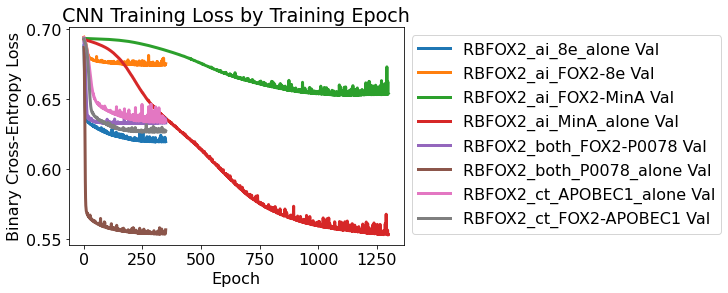

In [123]:
import matplotlib
from matplotlib import pyplot as plt

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

def quick_loss_plot(data_label_list,loss_type="Binary Cross-Entropy Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,(train_data,test_data,label) in enumerate(data_label_list):    
        #plt.plot(train_data,linestyle='--', label=f"{label} Train")
        plt.plot(test_data, label=f"{label} Val",linewidth=3.0)

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.title('CNN Training Loss by Training Epoch')

for category in sorted(model_per_category):
    model_features = model_per_category.get(category)
    data_label = (model_features.get('train_losses'),
                               model_features.get('val_losses'),
                               category)
    quick_loss_plot([data_label])
    
plt.savefig('cnn_figures/cnn_training_loss_by_epoch_3.svg', bbox_inches='tight')

# Validation set

RBFOX2_ai_8e_alone
RBFOX2_ai_MinA_alone
RBFOX2_both_P0078_alone
RBFOX2_ct_APOBEC1_alone


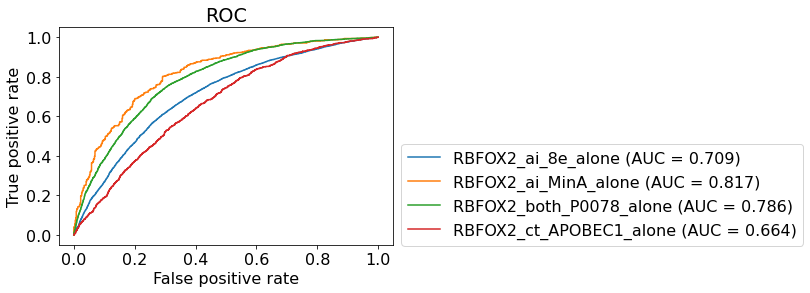

In [124]:
from sklearn import metrics

plt.figure()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC")

legend = []
for category in sorted(model_per_category):
    if 'alone' not in category:
        continue
    model_features = model_per_category.get(category)
    print(category)
    model = model_features.get('model')
    
    preds = []

    seqs = fusion_splits.get(category)
    if not seqs:
        seqs = alone_splits.get(category)
    
    for s in seqs.get('test')['seq']:
        s = torch.tensor(one_hot_encode(s)).unsqueeze(0).to(DEVICE)
        preds.append(model(s.float()))

    binary_predictions = np.array([float(p[0][0]) for p in preds])
    actual_values = np.array(seqs.get('test')['score'].values)

    fpr, tpr, thresholds = metrics.roc_curve(actual_values, binary_predictions, pos_label=1)
    auc = round(metrics.roc_auc_score(actual_values, binary_predictions), 3)

    plt.plot(fpr, tpr)

    legend.append("{} (AUC = {})".format(category, auc))
plt.legend(legend, bbox_to_anchor=(1, 0.5), loc='upper left')
plt.savefig("cnn_figures/ROC_enzyme_alone_3.svg", bbox_inches='tight')



RBFOX2_ai_FOX2-8e
RBFOX2_ai_FOX2-MinA
RBFOX2_both_FOX2-P0078
RBFOX2_ct_FOX2-APOBEC1


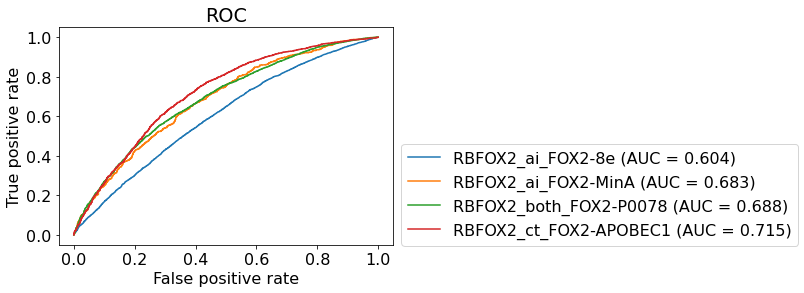

In [125]:
plt.figure()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC")
legend = []
for category in sorted(model_per_category):
    if 'alone' in category:
        continue
    model_features = model_per_category.get(category)
    print(category)
    model = model_features.get('model')
    
    preds = []

    seqs = fusion_splits.get(category)
    if not seqs:
        seqs = alone_splits.get(category)
    
    for s in seqs.get('test')['seq']:
        s = torch.tensor(one_hot_encode(s)).unsqueeze(0).to(DEVICE)
        preds.append(model(s.float()))

    binary_predictions = np.array([float(p[0][0]) for p in preds])
    actual_values = np.array(seqs.get('test')['score'].values)

    fpr, tpr, thresholds = metrics.roc_curve(actual_values, binary_predictions, pos_label=1)
    auc = round(metrics.roc_auc_score(actual_values, binary_predictions), 3)

    plt.plot(fpr, tpr)

    legend.append("{} (AUC = {})".format(category, auc))
plt.legend(legend,  bbox_to_anchor=(1, 0.5), loc='upper left')
plt.savefig("cnn_figures/ROC_fusion_3.svg", bbox_inches='tight')

# Save models

In [126]:
for category in sorted(model_per_category):
    print(category)
    model_features = model_per_category.get(category)
    print(category)
    model = model_features.get('model')
    torch.save(model.state_dict(), 'cnn_models/{}_3.pt'.format(category))

RBFOX2_ai_8e_alone
RBFOX2_ai_8e_alone
RBFOX2_ai_FOX2-8e
RBFOX2_ai_FOX2-8e
RBFOX2_ai_FOX2-MinA
RBFOX2_ai_FOX2-MinA
RBFOX2_ai_MinA_alone
RBFOX2_ai_MinA_alone
RBFOX2_both_FOX2-P0078
RBFOX2_both_FOX2-P0078
RBFOX2_both_P0078_alone
RBFOX2_both_P0078_alone
RBFOX2_ct_APOBEC1_alone
RBFOX2_ct_APOBEC1_alone
RBFOX2_ct_FOX2-APOBEC1
RBFOX2_ct_FOX2-APOBEC1


# ~~~~~~~~~~~~~~ Load saved models ~~~~~~~~~~~~~~~~

# RBFOX2-p0078 and RBFOX2-MinA filters at the end are missing

In [6]:
from glob import glob
import torch 
seq_len = 300

saved_models = {}
for model_path in glob('cnn_models/*_3.pt'):
    #model_saved = DNA_CNN_advanced(30, kernel_size=3, kernel_size_2=3, out_mp2=4)
    model_saved = DNA_CNN_advanced(seq_len, kernel_size=2, kernel_size_2=3, out_mp2=5)

    model_saved.load_state_dict(torch.load(model_path))
    model_saved.eval()
    
    saved_models[model_path.split('/')[-1].split('.pt')[0]] = model_saved

# Test enzyme only models on fusion datasets

In [7]:
alone_to_fusion = {
    'RBFOX2_both_P0078_alone': 'RBFOX2_both_FOX2-P0078',
    'RBFOX2_ai_8e_alone': 'RBFOX2_ai_FOX2-8e',
    'RBFOX2_ai_MinA_alone': 'RBFOX2_ai_FOX2-MinA',
    'RBFOX2_ct_APOBEC1_alone': 'RBFOX2_ct_FOX2-APOBEC1' 
}

fusion_to_alone = {v:k for k,v in alone_to_fusion.items()}
fusion_to_alone

{'RBFOX2_both_FOX2-P0078': 'RBFOX2_both_P0078_alone',
 'RBFOX2_ai_FOX2-8e': 'RBFOX2_ai_8e_alone',
 'RBFOX2_ai_FOX2-MinA': 'RBFOX2_ai_MinA_alone',
 'RBFOX2_ct_FOX2-APOBEC1': 'RBFOX2_ct_APOBEC1_alone'}

NameError: name 'model_per_category' is not defined

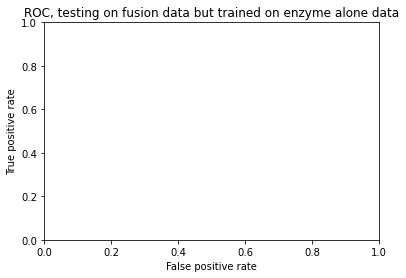

In [10]:
from matplotlib import pyplot as plt

plt.figure()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC, testing on fusion data but trained on enzyme alone data")

legend = []
for category in sorted(model_per_category):
    if 'alone' not in category:
        continue
    model_features = model_per_category.get(category)
    print(category)
    model = model_features.get('model')
    
    preds = []

    category_of_fusion = alone_to_fusion.get(category)
    seqs = fusion_splits.get(category_of_fusion)
    
    for s in seqs.get('train')['seq']:
        s = torch.tensor(one_hot_encode(s)).unsqueeze(0).to(DEVICE)
        preds.append(model(s.float()))

    binary_predictions = np.array([float(p[0][0]) for p in preds])
    actual_values = np.array(seqs.get('train')['score'].values)

    fpr, tpr, thresholds = metrics.roc_curve(actual_values, binary_predictions, pos_label=1)
    auc = round(metrics.roc_auc_score(actual_values, binary_predictions), 3)

    plt.plot(fpr, tpr)

    legend.append("{} (AUC = {})".format(category, auc))
plt.legend(legend, bbox_to_anchor=(1, 0.5), loc='upper left')
plt.savefig("cnn_figures/roc_test_on_fusion_but_trained_on_alone_3.svg", bbox_inches='tight')

RBFOX2_ai_FOX2-8e
RBFOX2_ai_FOX2-MinA
RBFOX2_both_FOX2-P0078
RBFOX2_ct_FOX2-APOBEC1


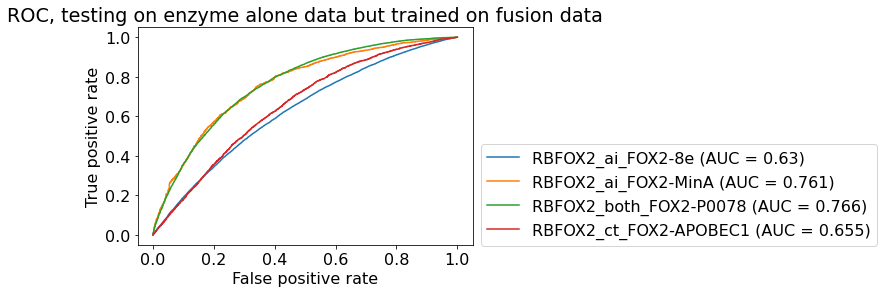

In [131]:
plt.figure()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC, testing on enzyme alone data but trained on fusion data")

legend = []
for category in sorted(model_per_category):
    if 'alone' in category:
        continue
    model_features = model_per_category.get(category)
    print(category)
    model = model_features.get('model')
    
    preds = []

    category_of_alone = fusion_to_alone.get(category)
    seqs = alone_splits.get(category_of_alone)
    
    for s in seqs.get('train')['seq']:
        s = torch.tensor(one_hot_encode(s)).unsqueeze(0).to(DEVICE)
        preds.append(model(s.float()))

    binary_predictions = np.array([float(p[0][0]) for p in preds])
    actual_values = np.array(seqs.get('train')['score'].values)

    fpr, tpr, thresholds = metrics.roc_curve(actual_values, binary_predictions, pos_label=1)
    auc = round(metrics.roc_auc_score(actual_values, binary_predictions), 3)

    plt.plot(fpr, tpr)

    legend.append("{} (AUC = {})".format(category, auc))
plt.legend(legend, bbox_to_anchor=(1, 0.5), loc='upper left')
plt.savefig("cnn_figures/roc_test_on_alone_but_trained_on_fusion_3.svg", bbox_inches='tight')

# View filters

In [132]:
import logomaker

def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv1d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv1d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    model_weights = model_weights[0]
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.cpu().detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()

In [153]:
import random

def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce and a convolutional layer, 
    get the output tensor containing the conv filter 
    activations along each position in the sequence
    '''
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(one_hot_encode(seq)).unsqueeze(0).permute(0,2,1).to(DEVICE)

    
    # run seq through conv layer
    with torch.no_grad(): # don't want as part of gradient graph
        # apply learned filters to input seq
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer,act_thresh=0):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run seq inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were > act_thresh. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter above the threshold act_thresh
    '''
    # initialize dict of pwms for each filter in the conv layer
    # pwm shape: 4 nucleotides X filter width, initialize to 0.0s
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[0]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        # get a tensor of each conv filter activation along the input seq
        res = get_conv_output_for_seq(seq, conv_layer)

        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            # collect the indices where the activation level 
            # was above the threshold
            act_idxs = torch.where(act_vec>act_thresh)[0]
            activated_positions = [x.item() for x in act_idxs]

            # use activated indicies to extract the actual DNA
            # subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                # transpose OHE to match PWM orientation
                subseq_tensor = torch.tensor(one_hot_encode(subseq)).T

                # add this subseq to the pwm count for this filter
                if len(subseq) == 2:
                    filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    '''
    Given some convolutional model weights and filter activation PWMs, 
    visualize the heatmap and motif logo pairs in a simple grid
    '''
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)

    # make sure the model weights agree with the number of filters
    assert(model_weights.shape[0] == len(filter_activations))
    
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1
    # ^ not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 17))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.cpu().detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(model_weights.shape[2]))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        #print(filt_df)
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')

        #filt_df_info = (filt_df.T/filt_df.T.sum()).T#= logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        #print(filt_df_info)
        filt_df_info = filt_df_info.fillna(0)
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        filt_df_info = filt_df_info
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()


RBFOX2_ai_MinA_alone
Total convolutional layers: 2
Num filters 32
filt_width 2
torch.Size([32, 4, 2])


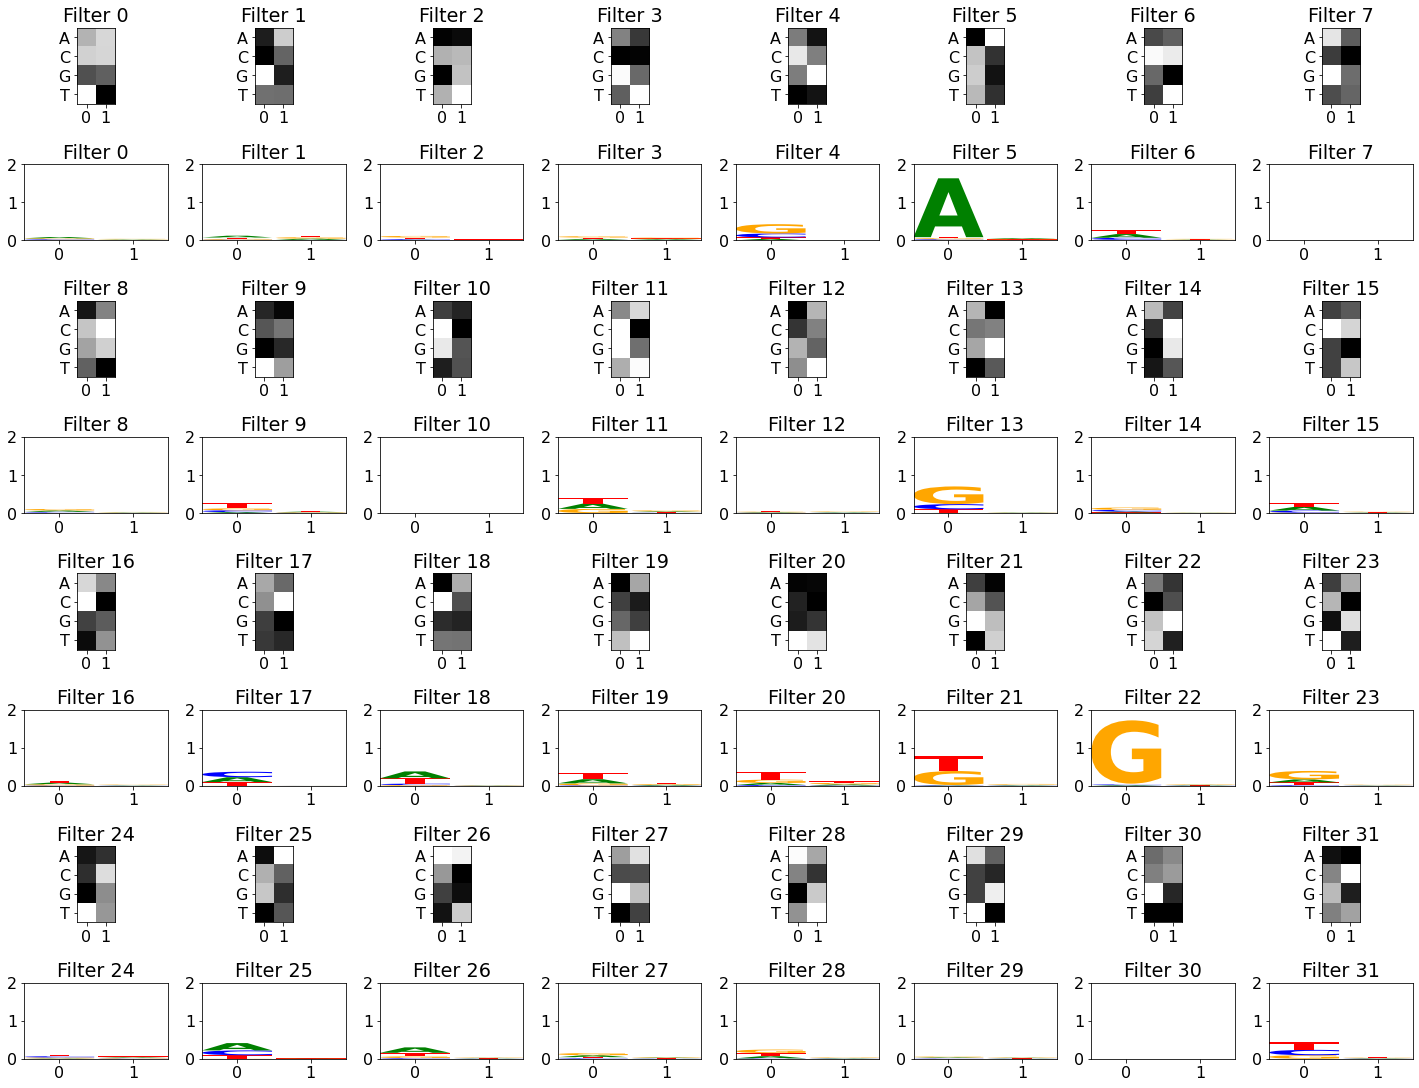

In [156]:

for category, model in model_per_category.items():
    if 'alone' not in category:
        continue
    print(category)
    try:
        seqs = fusion_splits.get(category).get('train').seq.values
    except Exception as e:
        seqs = alone_splits.get(category).get('train').seq.values
    #some_seqs = seqs
    some_seqs = random.choices(seqs, k=10)

    conv_layers, model_weights, bias_weights = get_conv_layers_from_model(model.get('model'))

    # just use some seqs from test_df to activate filters

    filter_activations = get_filter_activations(some_seqs, conv_layers[0],act_thresh=0)
    view_filters_and_logos(model_weights,filter_activations)
    plt.savefig('cnn_figures/filter_motifs_{}_3.svg'.format(category), bbox_inches='tight')
    break